# Introduction

## Context
Our customer, one of Europe most important retailers would like to introduce a sales forecasting system to optimize promotions and warehouse stocks.

## Objective
1. The goal of the project is to provide a working forecasting model and for each store the sum of product sold for March and April.
2. The provided training dataset contains daily information about number of sales, number of visitors, store information, weather information and demographic information.

## Activities
1. Perform a data analysis aimed at analyzing trends and correlation between the available information
2. Study and analyze solution/logics for the training set transformation and structuration
3. Design and train a forecast prediction model
4. Predict the sum of sales for each store for March and April.

## Preview

The whole data mining running files is this pynotebook. Each part combine the code(in python), some explainations(in markdown) and the result of each cell(in tables or a diagram) together. The file could be divided into several parts:

1. **A glance of data**: what are we dealing with, what we are going to predict, and with what we could do such predictions and ...
2. **Preprocessing the data**: normalize/rescale the data, handling with those missing values, parsing dates and ...
3. **Data internal relationships**: try to find those internal relationships in the data. From the point view of a data scientist, we should do the analysis fast and accurate, so we are going to select the most important attributes in the training set, instead of just throwing all of our preprocessed data into a training model.
4. **Model Selection**: anaylze the fact of our problem, select several suitable models and corresponding method to prevent from overfitting.
5. **Model Training**: divide the training data into 2/3 training set and 1/3 validation set, training the model with the training data.
6. **Model Validation**: we are going to validate the models. Since our computing resources are limited, we have to give up leave-one-out validation or 10-fold. Bootstrapping could be a good idea, but here we just seperate the data and validate our model with the 1/3 data we did not use for training.
7. **Computing the result**: discuss the models we derived and select the most properiate model. Compute the result for given testing data.

## Dataset Schema
[35 columns]
Store ID

Observation Date

Regional Holiday

Store Open

The Store is currently running promotions

Type of Store (Standard Market, Super Market, Hyper Market, Shopping Centre) 

Type of Products (General, With Fish Department, With Non-Food Department) 

Distance (meters) to the nearest competitor store

Number of Customer

Number of Products Sold (Target Value)

Region Size in which the Store is located (Km2)

Region ID

Region Gross Domestic Product

Region Population Size (k)

LevelofCovering(0-9)

Meteorological event

Max Dew Point (Celsius)

Max Gust Speed (Km/h)

Max Humidity

Max Pressure (hPa)

Max Temperature (Celsius)

Max Visibility (Km)

Max Wind Speed (Km/h)

Mean Dew Point (Celsius)

Mean Humidity

Mean Pressure (hPa)

Mean Temperature (Celsius)

Mean Visibility (Km)

Mean Window Speed (Km/h)

Min Dew Point (Celsius)

Min Humidity

Min Pressure (hPa)

Min Temperature (Celsius)

Min Visibility (Km)

Precipitation Amount (mm)

Window Direction (degrees)

## Output Format

StoreID

Month

NumberOfSales

In [1]:
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode,iplot
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn method
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR

import os

print (os.listdir(os.getcwd()))
# get the current content under the work path

['Submit Files', 'test(1).xlsx', '.DS_Store', 'train.xlsx', 'test.csv', 'Bip+xTech+-+Challenge+2018.pdf', 'POLIMI DMTM Project.ipynb', 'sample_submission.xlsx', 'result_sep.csv', 'test.xlsx', 'result.csv', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


# 1. A glance of data

## Check the given data, rescale/normalize/clean it

Before preprocessing the data, it's quite necessary to get a brief impression of what we are dealing with. Let's focusing on the given trainning data scheme.

We could divide all these columns into following sets:

1. ID[Store]
2. Time Information[Date/IsHoliday/...]
3. Geographical Information[Region/Region_GDP/...]
4. Store Information[StoreType/NumOfCustomers]
5. Meteorological Information[Max_TemperatureC/...]

and the target variable to predict:[Number of Sales]

In [2]:
cwd = os.getcwd()

train_df = pd.read_csv(cwd+'/train.csv')
test_df = pd.read_csv(cwd+'/test.csv')

sample_submission = pd.read_csv(cwd+'/sample_submission.csv')

In [3]:
train_df.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
0,1000,01/03/2016,0,1,0,Hyper Market,General,326,7,495,...,1,11.0,16,-2,70,1029,1,6.0,0.0,23
1,1000,02/03/2016,0,1,0,Hyper Market,General,326,7,608,...,3,13.0,10,-2,58,1025,1,10.0,0.0,56
2,1000,04/03/2016,0,1,0,Hyper Market,General,326,7,665,...,3,11.0,10,-3,55,1023,2,8.0,0.0,22
3,1000,05/03/2016,0,1,0,Hyper Market,General,326,7,630,...,3,15.0,10,-6,25,1022,-1,10.0,0.0,108
4,1000,06/03/2016,0,0,0,Hyper Market,General,326,7,0,...,1,12.0,5,-6,48,1022,-5,5.0,0.0,46


In [4]:
test_df.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,Region_AreaKM2,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
0,1000,01/03/2018,0,1,0,Hyper Market,General,326,7,9643,...,6,14.0,5,-1,46,1011,2,10.0,0.00,180
1,1000,02/03/2018,0,1,0,Hyper Market,General,326,7,9643,...,4,12.0,6,-1,52,1009,3,10.0,5.08,315
2,1000,03/03/2018,0,1,0,Hyper Market,General,326,7,9643,...,3,13.0,11,-3,41,1013,-2,10.0,0.00,210
3,1000,04/03/2018,0,0,0,Hyper Market,General,326,7,9643,...,6,11.0,18,-2,65,1002,1,6.0,3.05,193
4,1000,05/03/2018,0,1,1,Hyper Market,General,326,7,9643,...,6,10.0,23,-5,25,1000,2,8.0,0.25,247


In [5]:
sample_submission.head()

,StoreID,Month,NumberOfSales
0,1000,3,0
1,1000,4,0
2,1001,3,0
3,1001,4,0
4,1002,3,0


In [6]:
print(set(train_df.columns.values.tolist())-set(test_df.columns.tolist()))
# ['NumberOfSales', 'NumberOfCustomers'] are the columns lacked in the test set

set(['NumberOfSales', 'NumberOfCustomers'])


In [7]:
train_df.describe()

,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,523021.000000,523021.000000,523021.000000,523021.000000,523021.00000,523021.000000,523021.000000,523021.000000,523021.000000,523021.000000,...,523021.000000,511683.000000,523021.000000,523021.000000,523021.000000,523021.000000,523021.000000,511683.000000,523021.000000,523021.000000
mean,1373.953914,0.029718,0.829714,0.383292,8002.71122,5.713151,259.325073,4057.377536,12381.265718,14050.547848,...,10.273205,12.151025,11.724961,3.737584,51.375624,1012.078435,6.202315,7.223408,0.808278,170.458096
std,216.395820,0.169808,0.375884,0.486189,11537.70753,3.357190,185.857102,2729.630381,9140.692427,2755.425404,...,7.041167,4.978385,5.791031,5.909098,19.284023,8.699236,6.312993,4.899575,2.631428,101.728193
min,1000.000000,0.000000,0.000000,0.000000,47.00000,0.000000,0.000000,0.000000,344.000000,9893.000000,...,-13.000000,0.000000,2.000000,-18.000000,10.000000,970.000000,-15.000000,0.000000,0.000000,-1.000000
25%,1187.000000,0.000000,1.000000,0.000000,1057.00000,3.000000,166.000000,2573.000000,7215.000000,11849.000000,...,4.000000,10.000000,8.000000,-1.000000,36.000000,1007.000000,1.000000,3.000000,0.000000,75.000000
50%,1373.000000,0.000000,1.000000,0.000000,3321.00000,6.000000,251.000000,4020.000000,9643.000000,15017.000000,...,11.000000,11.000000,11.000000,4.000000,51.000000,1013.000000,7.000000,8.000000,0.000000,191.000000
75%,1561.000000,0.000000,1.000000,1.000000,9673.00000,9.000000,345.000000,5538.000000,15566.000000,15931.000000,...,16.000000,14.000000,14.000000,8.000000,66.000000,1018.000000,11.000000,10.000000,0.250000,250.000000
max,1748.000000,1.000000,1.000000,1.000000,85070.00000,10.000000,2206.000000,26641.000000,32221.000000,23931.000000,...,30.000000,31.000000,53.000000,18.000000,100.000000,1038.000000,24.000000,31.000000,58.930000,360.000000


In [8]:
train_df.describe(include = 'O')

,Date,StoreType,AssortmentType,Events
count,523021,523021,523021,398923
unique,729,4,3,21
top,04/06/2016,Hyper Market,General,Rain
freq,749,292769,296188,204733


In [9]:
train_df['AssortmentType'].unique()

array(['General', 'With Non-Food Department', 'With Fish Department'],
      dtype=object)

In [10]:
# first things we should do is to parse the date
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523021 entries, 0 to 523020
Data columns (total 36 columns):
StoreID                       523021 non-null int64
Date                          523021 non-null object
IsHoliday                     523021 non-null int64
IsOpen                        523021 non-null int64
HasPromotions                 523021 non-null int64
StoreType                     523021 non-null object
AssortmentType                523021 non-null object
NearestCompetitor             523021 non-null int64
Region                        523021 non-null int64
NumberOfCustomers             523021 non-null int64
NumberOfSales                 523021 non-null int64
Region_AreaKM2                523021 non-null int64
Region_GDP                    523021 non-null int64
Region_PopulationK            523021 non-null int64
CloudCover                    481840 non-null float64
Events                        398923 non-null object
Max_Dew_PointC                523021 non-null int64

In [11]:
train_df['Events'].unique()

array(['Rain-Snow', 'Snow', 'Rain', nan, 'Fog-Rain', 'Fog-Rain-Snow',
       'Fog', 'Rain-Thunderstorm', 'Rain-Hail', 'Fog-Rain-Thunderstorm',
       'Fog-Rain-Hail-Thunderstorm', 'Rain-Snow-Hail',
       'Fog-Rain-Snow-Hail', 'Fog-Snow', 'Snow-Hail', 'Fog-Thunderstorm',
       'Thunderstorm', 'Fog-Snow-Hail', 'Rain-Snow-Hail-Thunderstorm',
       'Fog-Rain-Hail', 'Rain-Hail-Thunderstorm',
       'Rain-Snow-Thunderstorm'], dtype=object)

# 2. Preprocessing the data

## Preprocessing Data-Parsing date

Here after a view of our data, we have 36 columns(incluing the default index starting from 1). 32 of them are numerical values. For those exceptions：

1. Date: we have to parse the date in the date format
2. StoreType: we have 4 different store types, Standard Market, Super Market, Hyper Market, Shopping Centre, since we could find a order in those attributes, we could assign each type a value, from standard to shopping center, there are assigned 1,2,3,4.
3. AssortmentType: we have 3 different object in this column, they are 'General', 'With Non-Food Department', 'With Fish Department'. No clearly relationships could be derived in an order, we are going to use ONE HOT ENCODING in this column
4. Events: we have two idea for this column, firstly, we could generalize their characters and divide into several categories like "Good/Not bad/Bad/Too bad to go shopping". This may lose a lot information but will bring the convience in the calculation. Another choice is do the ONE HOT ENCODING for this column as well.

In [12]:
train_df['Date'].dtype

dtype('O')

In [13]:
train_df['ParsedDate'] = pd.to_datetime(train_df['Date'],format="%d/%m/%Y")
train_df['ParsedDate'].head(5)

0   2016-03-01
1   2016-03-02
2   2016-03-04
3   2016-03-05
4   2016-03-06
Name: ParsedDate, dtype: datetime64[ns]

In [14]:
test_df['ParsedDate'] = pd.to_datetime(train_df['Date'],format="%d/%m/%Y")
train_df['ParsedDate'].head(5)

0   2016-03-01
1   2016-03-02
2   2016-03-04
3   2016-03-05
4   2016-03-06
Name: ParsedDate, dtype: datetime64[ns]

In [15]:
train_df['StoreType'].unique()

array(['Hyper Market', 'Super Market', 'Standard Market',
       'Shopping Center'], dtype=object)

In [16]:
storeTypeMapping={'Hyper Market':3, 'Super Market':2, 'Standard Market':1,'Shopping Center':4}
train_df['StoreType'] = train_df['StoreType'].map(storeTypeMapping)
train_df['StoreType'].head(5)
test_df['StoreType'] = test_df['StoreType'].map(storeTypeMapping)
test_df['StoreType'].head(5)

0    3
1    3
2    3
3    3
4    3
Name: StoreType, dtype: int64

## Review our data

We leave the one hot encoding in the later data processing. Now check our pre-processed data again.

In [17]:
# train_df=train_df.drop(['Date'], axis=1)
# test_df=test_df.drop(['Date'],axis=1)

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523021 entries, 0 to 523020
Data columns (total 37 columns):
StoreID                       523021 non-null int64
Date                          523021 non-null object
IsHoliday                     523021 non-null int64
IsOpen                        523021 non-null int64
HasPromotions                 523021 non-null int64
StoreType                     523021 non-null int64
AssortmentType                523021 non-null object
NearestCompetitor             523021 non-null int64
Region                        523021 non-null int64
NumberOfCustomers             523021 non-null int64
NumberOfSales                 523021 non-null int64
Region_AreaKM2                523021 non-null int64
Region_GDP                    523021 non-null int64
Region_PopulationK            523021 non-null int64
CloudCover                    481840 non-null float64
Events                        398923 non-null object
Max_Dew_PointC                523021 non-null int64


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45689 entries, 0 to 45688
Data columns (total 35 columns):
StoreID                       45689 non-null int64
Date                          45689 non-null object
IsHoliday                     45689 non-null int64
IsOpen                        45689 non-null int64
HasPromotions                 45689 non-null int64
StoreType                     45689 non-null int64
AssortmentType                45689 non-null object
NearestCompetitor             45689 non-null int64
Region                        45689 non-null int64
Region_AreaKM2                45689 non-null int64
Region_GDP                    45689 non-null int64
Region_PopulationK            45689 non-null int64
CloudCover                    37271 non-null float64
Events                        29248 non-null object
Max_Dew_PointC                45689 non-null int64
Max_Gust_SpeedKm_h            11251 non-null float64
Max_Humidity                  45689 non-null int64
Max_Sea_Level_Pre

### Dealing with the missing values

In [20]:
missing_val = train_df.isnull().sum()
missing_val

StoreID                            0
Date                               0
IsHoliday                          0
IsOpen                             0
HasPromotions                      0
StoreType                          0
AssortmentType                     0
NearestCompetitor                  0
Region                             0
NumberOfCustomers                  0
NumberOfSales                      0
Region_AreaKM2                     0
Region_GDP                         0
Region_PopulationK                 0
CloudCover                     41181
Events                        124098
Max_Dew_PointC                     0
Max_Gust_SpeedKm_h            409947
Max_Humidity                       0
Max_Sea_Level_PressurehPa          0
Max_TemperatureC                   0
Max_VisibilityKm               11338
Max_Wind_SpeedKm_h                 0
Mean_Dew_PointC                    0
Mean_Humidity                      0
Mean_Sea_Level_PressurehPa         0
Mean_TemperatureC                  0
M

In [21]:
missing_val_test = test_df.isnull().sum()
missing_val_test

StoreID                           0
Date                              0
IsHoliday                         0
IsOpen                            0
HasPromotions                     0
StoreType                         0
AssortmentType                    0
NearestCompetitor                 0
Region                            0
Region_AreaKM2                    0
Region_GDP                        0
Region_PopulationK                0
CloudCover                     8418
Events                        16441
Max_Dew_PointC                    0
Max_Gust_SpeedKm_h            34438
Max_Humidity                      0
Max_Sea_Level_PressurehPa         0
Max_TemperatureC                  0
Max_VisibilityKm               2621
Max_Wind_SpeedKm_h                0
Mean_Dew_PointC                   0
Mean_Humidity                     0
Mean_Sea_Level_PressurehPa        0
Mean_TemperatureC                 0
Mean_VisibilityKm              2621
Mean_Wind_SpeedKm_h               0
Min_Dew_PointC              

### Analysis with those missing values

In all the attributes, we have those following values as the missing value:

CloudCover(41k)
Events(123k)
MaxGustSpeedKmh(409k)
MaxVisibility(11k)
MeanVisibility(11k)
MinVisibility(11k)

Firstly, we have 523k samples in the given training set, while about 80% of them are null values in MaxGustSpd, this attribue if has no strong connections with our target values, we could just drop this columns

Now let's consider the problem we are given, we are going to calculate the sales and customers for some given information. We could make some arbitrary conclusion here, **this value has some strong connections with the store information, some selling events, weather condition**, so even if we have 20% missing values in the weather events, we still have to take this into consideration. 

As for the cloud cover and visibility information, I go through a great amount of data because I want to know one question. **Why we have null information in these data?**

I have two explaination for this question:
1. Because some stores are small and do not have the device to record these information[then we have to consider it with the store type]
2. Bacause of some specific reasons, those values are just be forgotten to record

Due to the given training sets, I found that for the same store, the value of cloud cover and visibility information are sometimes missed. This proved a fact that each store could record those values, the missing values are caused by the second explaination.Thus we could use an average value to substitutte it.

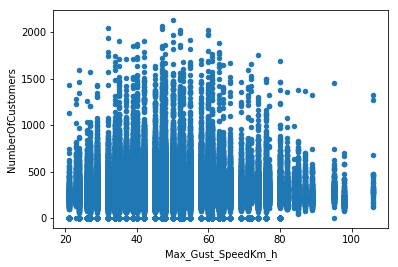

In [22]:
# let's check the MGSK, if the relationship between this value and our target values are weak, 
# we could just drop this value

var = 'Max_Gust_SpeedKm_h'
correlatedData = pd.concat([train_df['NumberOfCustomers'],train_df[var]],axis = 1)
correlatedData.plot.scatter(x=var,y='NumberOfCustomers')

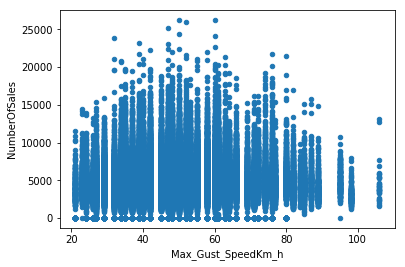

In [23]:
var = 'Max_Gust_SpeedKm_h'
correlatedData = pd.concat([train_df['NumberOfSales'],train_df[var]],axis = 1)
correlatedData.plot.scatter(x=var,y='NumberOfSales')

from the above scatter diagram, we could see a fact, intuitively we could not get any strong connection between guest speed and sales, so we would like to drop this column in the analysis

In [24]:
train_df = train_df.drop(['Max_Gust_SpeedKm_h'],axis=1)
test_df = test_df.drop(['Max_Gust_SpeedKm_h'],axis=1)

Now let's substitute the visibility null values and cloud cover with average values.

In [25]:
var_list = ['CloudCover','Max_VisibilityKm','Mean_VisibilityKm','Min_VisibilitykM']

for var in var_list:
    mean_val = train_df[var].mean()
#     print(mean_val)
    train_df[var] = train_df[var].fillna(mean_val)
    
for var in var_list:
    mean_val_test = test_df[var].mean()
#     print(mean_val_test)
    test_df[var] = test_df[var].fillna(mean_val)

Now let's check the event:

I think maybe this would be the biggest problem we met in the missing value handling of this scenario. 

In [26]:
train_df['Events'].unique()

array(['Rain-Snow', 'Snow', 'Rain', nan, 'Fog-Rain', 'Fog-Rain-Snow',
       'Fog', 'Rain-Thunderstorm', 'Rain-Hail', 'Fog-Rain-Thunderstorm',
       'Fog-Rain-Hail-Thunderstorm', 'Rain-Snow-Hail',
       'Fog-Rain-Snow-Hail', 'Fog-Snow', 'Snow-Hail', 'Fog-Thunderstorm',
       'Thunderstorm', 'Fog-Snow-Hail', 'Rain-Snow-Hail-Thunderstorm',
       'Fog-Rain-Hail', 'Rain-Hail-Thunderstorm',
       'Rain-Snow-Thunderstorm'], dtype=object)

After asked some further information about the "Events" attributes, we could get the fact that all the missing values could be regarded as "Normal Weathers". But we are we going to filling our data frame with Normal?

Here we do some further analysis on the attribute events, we could observe it is combined by several sub-attributes:

Rain

Snow

Fog

Thunderstorm

Hail

With this conclusion, we could find fact that we have to make the column 'Events' into 5 different columns, and each column is a bool type (0/1). Hence we would be able to build our model based on this attributes.

In [27]:
# train_df['Events'] = train_df['Events'].fillna('Normal')

In [28]:
attributesList = ['Rain','Snow','Fog','Thunderstorm','Hail']

for a in attributesList:
    train_df[a] = 0
    
for index, row in train_df.iterrows():
    if row['Events'] == None:
        continue
    else:
        s = str(row['Events'])
        for a in attributesList:
            if a in s:
#                 train_df.set_value(index,a,1)
                train_df.at[index, a]=1
                
train_df.head(10)
                

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,ParsedDate,Rain,Snow,Fog,Thunderstorm,Hail
0,1000,01/03/2016,0,1,0,3,General,326,7,495,...,1,6.0,0.00,23,2016-03-01,1,1,0,0,0
1,1000,02/03/2016,0,1,0,3,General,326,7,608,...,1,10.0,0.00,56,2016-03-02,0,1,0,0,0
2,1000,04/03/2016,0,1,0,3,General,326,7,665,...,2,8.0,0.00,22,2016-03-04,1,0,0,0,0
3,1000,05/03/2016,0,1,0,3,General,326,7,630,...,-1,10.0,0.00,108,2016-03-05,0,0,0,0,0
4,1000,06/03/2016,0,0,0,3,General,326,7,0,...,-5,5.0,0.00,46,2016-03-06,0,0,0,0,0
5,1000,07/03/2016,0,1,1,3,General,326,7,763,...,-2,16.0,0.00,68,2016-03-07,0,0,0,0,0
6,1000,08/03/2016,0,1,1,3,General,326,7,675,...,-2,18.0,0.00,62,2016-03-08,0,0,0,0,0
7,1000,09/03/2016,0,1,1,3,General,326,7,690,...,-1,13.0,0.00,53,2016-03-09,0,0,0,0,0
8,1000,10/03/2016,0,1,1,3,General,326,7,617,...,6,7.0,0.00,54,2016-03-10,1,0,0,0,0
9,1000,11/03/2016,0,1,1,3,General,326,7,636,...,7,6.0,0.51,30,2016-03-11,1,0,0,0,0


In [29]:
train_df['Events'].head(10)

0    Rain-Snow
1         Snow
2         Rain
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8         Rain
9         Rain
Name: Events, dtype: object

In [30]:
attributesList = ['Rain','Snow','Fog','Thunderstorm','Hail']

for a in attributesList:
    test_df[a] = 0
    
for index, row in test_df.iterrows():
    if row['Events'] == None:
        continue
    else:
        s = str(row['Events'])
        for a in attributesList:
            if a in s:
                test_df.at[index, a]=1
                
test_df.head(10)

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,Region_AreaKM2,...,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,ParsedDate,Rain,Snow,Fog,Thunderstorm,Hail
0,1000,01/03/2018,0,1,0,3,General,326,7,9643,...,2,10.0,0.00,180,2016-03-01,1,0,0,0,0
1,1000,02/03/2018,0,1,0,3,General,326,7,9643,...,3,10.0,5.08,315,2016-03-02,1,0,0,0,0
2,1000,03/03/2018,0,1,0,3,General,326,7,9643,...,-2,10.0,0.00,210,2016-03-04,1,0,1,0,0
3,1000,04/03/2018,0,0,0,3,General,326,7,9643,...,1,6.0,3.05,193,2016-03-05,1,0,0,0,0
4,1000,05/03/2018,0,1,1,3,General,326,7,9643,...,2,8.0,0.25,247,2016-03-06,1,1,0,0,0
5,1000,06/03/2018,0,1,1,3,General,326,7,9643,...,0,10.0,0.51,213,2016-03-07,1,0,0,0,0
6,1000,07/03/2018,0,1,1,3,General,326,7,9643,...,1,10.0,0.25,230,2016-03-08,1,0,0,1,0
7,1000,08/03/2018,0,1,1,3,General,326,7,9643,...,1,10.0,0.00,309,2016-03-09,1,0,0,0,0
8,1000,09/03/2018,0,1,1,3,General,326,7,9643,...,-2,10.0,0.00,190,2016-03-10,0,0,0,0,0
9,1000,10/03/2018,0,1,0,3,General,326,7,9643,...,-3,18.0,0.00,178,2016-03-11,0,0,0,0,0


In [31]:
test_df['Events'].head(10)

0                 Rain
1                 Rain
2             Fog-Rain
3                 Rain
4            Rain-Snow
5                 Rain
6    Rain-Thunderstorm
7                 Rain
8                  NaN
9                  NaN
Name: Events, dtype: object

In [32]:
train_df = train_df.drop(['Events'], axis=1)
test_df = test_df.drop('Events',axis=1)

Now we have finished the preprocessing in the data, let's dive into the real job!

# 3. Data internal relationships

After reviewing this problem, I think it is quite useful if we could lock some "KEY" informations. We could find what's contributing most to our target values. The first intuitive choice is that the Number of Sales is strongly linear related with the Number of Customers. 

In this scenario, we have two values to predict. While it would be far more better if we could use one and derive another.

And I also have some assumptions:



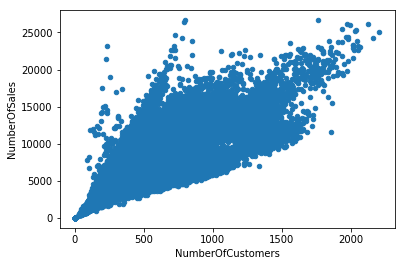

In [33]:
var = 'NumberOfCustomers'
correlatedData = pd.concat([train_df['NumberOfSales'],train_df[var]],axis = 1)
correlatedData.plot.scatter(x=var,y='NumberOfSales')

## NumberOfCustomers: how are we going to use this value?

According to this diagram, we could derive one conclusion which quite meets our common knowledge, "more people, more sales". Even the shape of the scatter is like a convex and we could not get a numerical liear relationship from this, but still they are strongly related.

While here comes an important problem: we don't have any information about number of customer in the testing set, here one problem rises:**should we just don't drop the NumberOfCustomers? Or should we take NumberOfCustomers and NumberOfSales into consideration at the same time?**

Intuitively I think maybe it will be better that we just drop the number of customer in the training set. Cuz we have no number of customers given in the test set, and this value are not required by our clients. It is a hard choice to do, but it is necessary in the current situation.

While as a data scientist, I have to reasonably consider this scenario in a complete way. So here we would like to support my assumption in this section: I am going to use a heap map to get the information of *What's the correlated information between NumberOfSales and other attributes* and *What's the correlated information between NumberOfCustomers and other attributes*.

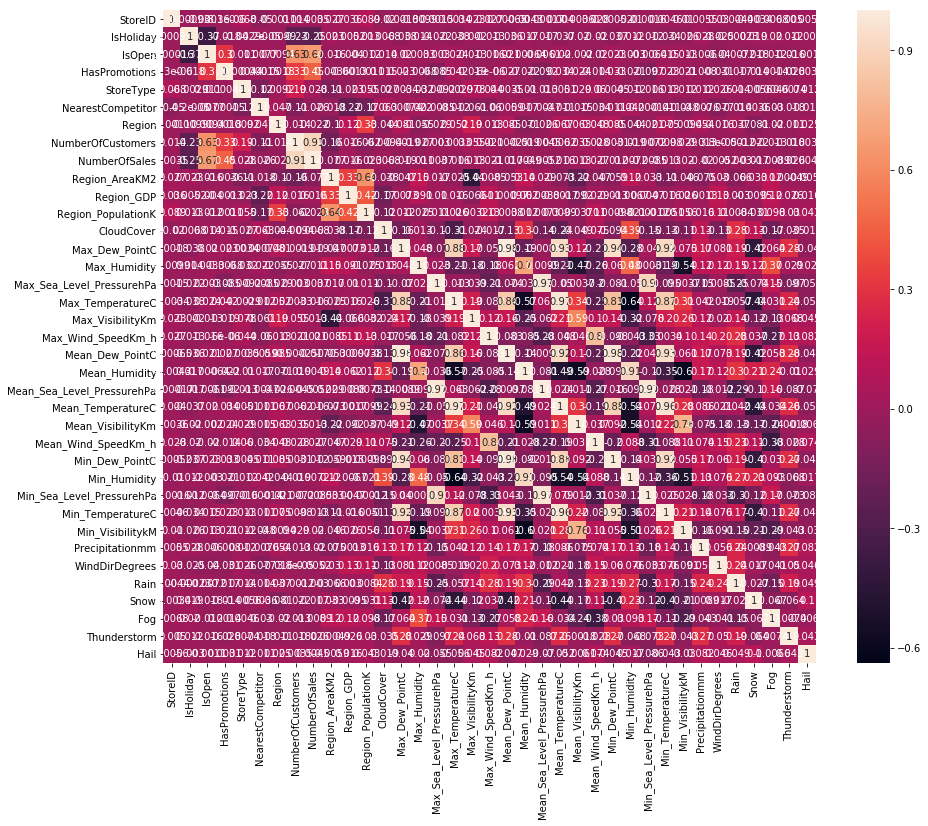

In [34]:
corrmat = train_df.corr()
# print(corrmat)
fig, ax = plt.subplots(figsize = (15,12))
fig = sns.heatmap(corrmat, vmax=1, square = True,annot = True)

Now let's check the heatmap above.

I would like to split this heat map into several pieces, the attributes from StoreID to CloudCover and the attributes from CloudCover to the end.

We do such splition because we found a fact that the right corner of the square have some strong relationships. Why? Becasue for each weather information we have MAX/MIN/MEAN three values, and of course they are highly corelated.

Take the Temperature for an example, they are highly-correlated to each other, so we have to consider one problem, do we really need some many "Temperature" information here? I think the answer is negative.

Index([u'NumberOfSales', u'NumberOfCustomers', u'IsOpen', u'HasPromotions',
       u'StoreType', u'Mean_Wind_SpeedKm_h', u'Max_Wind_SpeedKm_h',
       u'Min_VisibilitykM', u'Region_GDP', u'Mean_VisibilityKm',
       u'Max_VisibilityKm', u'Min_Humidity', u'CloudCover', u'Mean_Humidity',
       u'Hail', u'Max_Sea_Level_PressurehPa', u'StoreID', u'Rain',
       u'Mean_Sea_Level_PressurehPa', u'WindDirDegrees'],
      dtype='object')


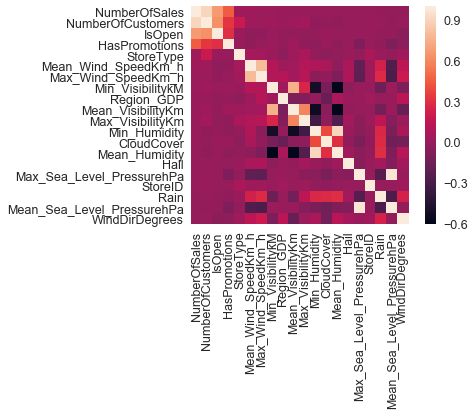

In [35]:
k = 20
cols = corrmat.nlargest(k,'NumberOfSales')['NumberOfSales'].index
print(cols)
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm,cbar = True, square = True, fmt = '.2f', annot_kws={'size':10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

from above diagram, we could get the most important values related to the number of sales(from highly related to hardly related):

IsOpen(Sure!)

HasPromotions

StoreType

MeanWindSpeed(we use this to generalize all wind speed information)

MinVisibilityKM

RegionGDP

MinHumidity

CloudCover

SeaLevelPressure

StoreID

We could find a fact that the relationship between the min_humidity, cloud cover is strong, so we could only use the min humidity and drop cloud cover.




Index([u'NumberOfCustomers', u'NumberOfSales', u'IsOpen', u'HasPromotions',
       u'StoreType', u'Max_VisibilityKm', u'Mean_VisibilityKm',
       u'Min_VisibilitykM', u'Mean_Wind_SpeedKm_h', u'Max_Wind_SpeedKm_h',
       u'Region_GDP', u'StoreID', u'Min_TemperatureC', u'Mean_TemperatureC',
       u'Hail', u'Max_TemperatureC', u'Min_Dew_PointC',
       u'Max_Sea_Level_PressurehPa', u'WindDirDegrees', u'Mean_Dew_PointC'],
      dtype='object')


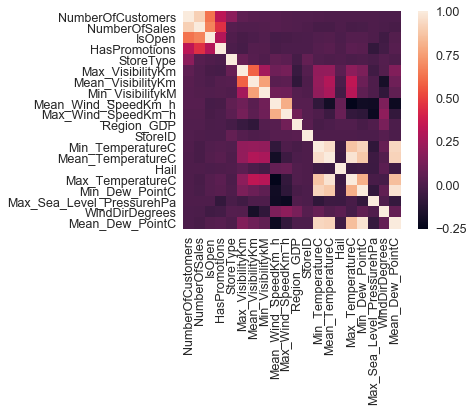

In [36]:
k = 20
cols = corrmat.nlargest(k,'NumberOfCustomers')['NumberOfCustomers'].index
print(cols)
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm,cbar = True, square = True, fmt = '.2f', annot_kws={'size':10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Index([u'IsHoliday', u'Region_AreaKM2', u'NearestCompetitor',
       u'Region_PopulationK', u'Max_Humidity', u'Snow', u'Mean_Humidity',
       u'Min_Humidity', u'Thunderstorm', u'Region', u'Precipitationmm', u'Fog',
       u'CloudCover', u'Min_Sea_Level_PressurehPa',
       u'Mean_Sea_Level_PressurehPa', u'Max_Dew_PointC', u'Rain',
       u'Mean_Dew_PointC', u'WindDirDegrees', u'Max_Sea_Level_PressurehPa'],
      dtype='object')


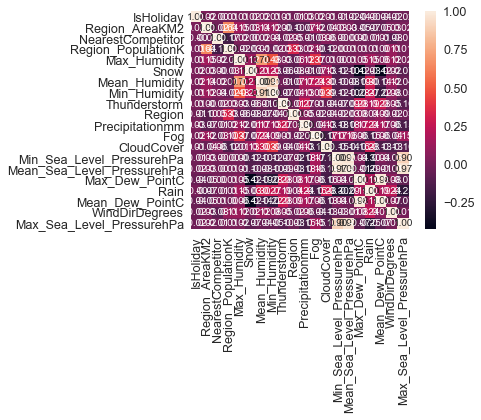

In [37]:
k = 20
cols = corrmat.nsmallest(k,'NumberOfCustomers')['NumberOfCustomers'].index
print(cols)
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm,cbar = True, square = True, annot = True,fmt = '.2f', annot_kws={'size':10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let's compare the above two heatmaps. They are heatmap of top20 attributes related with NumberOfCustomers and NumberOfSales. The idea is that since **NumberOfCustomer's relationship with other attributes** is not strongly better than the **NumberOfSales relationship with other attributes**, it would not help that we predict the number of customers first and then use it to estimate the number of customers.

Hence we reach an conclusion: we should drop the NumberOfCustomers in the training of our model.

In [38]:
train_df = train_df.drop(['NumberOfCustomers'],axis = 1)

In [39]:
# sns.set()

# # cols = ['IsOpen','HasPromotions','StoreType','Mean_Wind_SpeedKm_h','Mean_VisibilityKm','Region_GDP','Min_Humidity',
# #         'Max_Sea_Level_PressurehPa']

# cols = ['NumberOfSales','IsOpen','HasPromotions','StoreType','Mean_Wind_SpeedKm_h','Mean_VisibilityKm','Region_GDP','Min_Humidity']

# sns.pairplot(train_df[cols],size = 2.5)
# plt.show()

# it took long time to compute all the scatter statistics between all the cols. It makes no sense that we 
# research the relaionship between the windspeed and GDP, so I use next cell to get brieft information 
# but still uncomment this cell could have a verl general view of data we are processing.

In [40]:
# g = sns.PairGrid(train_df, y_vars=["NumberOfSales"], 
#                  x_vars=['IsOpen','HasPromotions','StoreType','Mean_Wind_SpeedKm_h','Mean_VisibilityKm',
#                          'Region_GDP','Min_Humidity'], size=4)
# g.map(sns.regplot, color=".3")
# g.set(ylim=(-1, 11), yticks=[0, 5, 10]);

Although we already know some of the main figures, this MEGA figure collection gives us a reasonable idea if about variable relationships.

In [41]:
# df = train_df[['NumberOfSales','Events']]
# import plotly.graph_objs as go

# trace = go.Bar(x = df.Events,
#               y = df.NumberOfSales,
#               name = "relationships",
#               marker = dict(color='rgba(255,174,255,0.5)',
#                            line = dict(color = 'rgb(0,0,0)',width=1.5)))

# layout = go.Layout(barmode="group")
# fig = go.Figure(data = [trace], layout = layout)
# iplot(fig,)


## Scale and Normalize the data

In this part, we would like to check further information in the data of ['NumberOfSales','IsOpen','HasPromotions','StoreType','Mean_Wind_SpeedKm_h','Mean_VisibilityKm','Region_GDP','Min_Humidity','IsHoliday','Region_AreaKM2','NearestCompetitor','Region_PopulationK','StoreType','Rain','Snow','Fog','Thunderstorm','Hail']

Hence I create a new data frame and called real_train_df, only including the above columns and do the scale and normalize on this data.

In [42]:
real_train_df = train_df[['NumberOfSales','IsOpen','HasPromotions','StoreType','Region','Mean_Wind_SpeedKm_h','Mean_VisibilityKm','Region_GDP','Min_Humidity','IsHoliday','Region_AreaKM2','NearestCompetitor','Region_PopulationK','StoreType','Rain','Snow','Fog','Thunderstorm','Hail']]
# real_train_df = train_df['NumberOfSales']
real_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523021 entries, 0 to 523020
Data columns (total 19 columns):
NumberOfSales          523021 non-null int64
IsOpen                 523021 non-null int64
HasPromotions          523021 non-null int64
StoreType              523021 non-null int64
Region                 523021 non-null int64
Mean_Wind_SpeedKm_h    523021 non-null int64
Mean_VisibilityKm      523021 non-null float64
Region_GDP             523021 non-null int64
Min_Humidity           523021 non-null int64
IsHoliday              523021 non-null int64
Region_AreaKM2         523021 non-null int64
NearestCompetitor      523021 non-null int64
Region_PopulationK     523021 non-null int64
StoreType              523021 non-null int64
Rain                   523021 non-null int64
Snow                   523021 non-null int64
Fog                    523021 non-null int64
Thunderstorm           523021 non-null int64
Hail                   523021 non-null int64
dtypes: float64(1), int64(18)
me

It is not hard to find a fact, that the Region_GDP, Region_AreaKM2, and Region_Popoluation has scale far more greater than other attributes, to minimize the side effect brought by different numerical scales, we could try to scale those numbers in a range, let's say, like from 0 to 100. While is this a really necessary? Because in this data frame, in the consideration of regression problem, this effect could be ignored under a small number of coefficient. 

# 4. Model Selection

Since we are facing a regression problem (with many attributes and trying to calculate a numerical value): we have several potential methods to use.[only potential methods we learned in this course]

Firstly, we are dealing with about 520k samples, it means it is not possible to use a lazy-model(of course we still could, but it cost really a lot in the real practice.). Hence we could not use methods like KNN.

While in such kind of models, SVM could be a promising choice. Since SVM performs quite well in the space of high dimension, we could SVM become one of our choice.

And we are dealing with this regression, so ridge regression and lasso regression could also be helpful here. 

But first, let's split the data.

In [43]:
random_seed=2

inputs = real_train_df.drop(['NumberOfSales'],axis=1)
labels = real_train_df[['Region','NumberOfSales']]

x_train,x_val,y_train,y_val = train_test_split(inputs,labels,test_size=0.3,random_state=random_seed)

# 5. Model Training

## Error Function

We are going to calculate the total error in the demand, so it is not approperiate to just use the sklearn accuracy score function between the prediction and actually values, we have to made these values into one new dataframe composed by two attributes 'Region' and 'NumberOfSales'


In [44]:
train_df['Region'].unique()

array([ 7,  0,  3,  2,  9, 10,  4,  1,  5,  6,  8])

In [45]:
d = {'Reg': [0,1,2,3,4,5,6,7,8,9,10], 'Sale': [0,0,0,0,0,0,0,0,0,0,0]}
regional_val = pd.DataFrame(d)
    
for index, row in y_val.iterrows():
    regional_val.at[row['Region'],'Sale']+=row['NumberOfSales']
                
regional_val.head(11)

,Reg,Sale
0,0,48433068
1,1,19704414
2,2,77675218
3,3,98773780
4,4,19154453
5,5,41441519
6,6,27712233
7,7,53193605
8,8,21182323
9,9,150943590


## Linear Regression

In [46]:
# the general Linear Regression is listed as an check for the importance of model complexity selection


lr = LinearRegression()
lr.fit(x_train,y_train['NumberOfSales'])
_y_pred = lr.predict(x_val)
print("The MSE of Linear Regression is")
print(mean_squared_error(y_val['NumberOfSales'], _y_pred))

The MSE of Linear Regression is
3427987.7489207825


In [47]:
d = pd.DataFrame(_y_pred, columns=['Sale'])
d.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
d = pd.concat([d, y_val], axis=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156907 entries, 0 to 156906
Data columns (total 3 columns):
Sale             156907 non-null float64
Region           156907 non-null int64
NumberOfSales    156907 non-null int64
dtypes: float64(1), int64(2)
memory usage: 3.6 MB


In [48]:
regional_pred = pd.DataFrame({'Reg': [0,1,2,3,4,5,6,7,8,9,10], 'Sale': [0,0,0,0,0,0,0,0,0,0,0]})

for index, row in d.iterrows():
    regional_pred.at[int(row['Region']),'Sale']+=row['Sale']
                
regional_pred.head(11)

,Reg,Sale
0,0,50996428
1,1,22109579
2,2,73752619
3,3,91361064
4,4,19655890
5,5,42366052
6,6,30737896
7,7,56116116
8,8,23667117
9,9,151370773


In [49]:
# Error on regions
print("The Error of Linear Regression on the regional scale is")
print((regional_val['Sale']-regional_pred['Sale'])/regional_val['Sale'])
print(sum((regional_val['Sale']-regional_pred['Sale'])/regional_val['Sale'])/11)

The Error of Linear Regression on the regional scale is
0    -0.052926
1    -0.122062
2     0.050500
3     0.075047
4    -0.026179
5    -0.022309
6    -0.109181
7    -0.054941
8    -0.117305
9    -0.002830
10    0.048382
Name: Sale, dtype: float64
-0.0303458329143


In [50]:
x_val_isOpen=pd.DataFrame(x_val['IsOpen'])
x_val_isOpen.reset_index(drop=True, inplace=True)
d = pd.concat([d, x_val_isOpen], axis=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156907 entries, 0 to 156906
Data columns (total 4 columns):
Sale             156907 non-null float64
Region           156907 non-null int64
NumberOfSales    156907 non-null int64
IsOpen           156907 non-null int64
dtypes: float64(1), int64(3)
memory usage: 4.8 MB


In [51]:
regional_pred_priorK = pd.DataFrame({'Reg': [0,1,2,3,4,5,6,7,8,9,10], 'Sale': [0,0,0,0,0,0,0,0,0,0,0]})

for index, row in d.iterrows():
    if row['IsOpen']==1:
        regional_pred_priorK.at[int(row['Region']),'Sale']+=row['Sale']
                
regional_pred_priorK.head(11)

,Reg,Sale
0,0,50585346
1,1,21996290
2,2,74938994
3,3,89975083
4,4,19148995
5,5,42851676
6,6,30871874
7,7,55984135
8,8,23926747
9,9,151060211


In [52]:
# Error on regions
print("The Error of Linear Regression on the regional scale is")
print((regional_val['Sale']-regional_pred_priorK['Sale'])/regional_val['Sale'])
print(sum((regional_val['Sale']-regional_pred_priorK['Sale'])/regional_val['Sale'])/11)

The Error of Linear Regression on the regional scale is
0    -0.044438
1    -0.116313
2     0.035226
3     0.089079
4     0.000285
5    -0.034028
6    -0.114016
7    -0.052460
8    -0.129562
9    -0.000773
10    0.036580
Name: Sale, dtype: float64
-0.0300380929776


Here is the before result:
0    -0.053091
1    -0.118816
2     0.051380
3     0.073954
4    -0.012502
5    -0.018598
6    -0.110850
7    -0.064127
8    -0.147938
9    -0.001981
10    0.055369
We could find a fact that we have some little improvements. But this also derive another idea, now we are training the model with all the datas, what if we train the model with on data that IsOpen==1? Could we get a more precise model?

In [53]:
real_train_df_IsOpen = real_train_df.loc[real_train_df['IsOpen'] == 1]

random_seed=2

inputs_IsOpen = real_train_df_IsOpen.drop(['NumberOfSales'],axis=1)
labels_IsOpen = real_train_df_IsOpen[['Region','NumberOfSales']]

x_train_io,x_val_io,y_train_io,y_val_io = train_test_split(inputs_IsOpen,labels_IsOpen,test_size=0.3,random_state=random_seed)

In [54]:
d = {'Reg': [0,1,2,3,4,5,6,7,8,9,10], 'Sale': [0,0,0,0,0,0,0,0,0,0,0]}
regional_val_io = pd.DataFrame(d)
    
for index, row in y_val_io.iterrows():
    regional_val_io.at[row['Region'],'Sale']+=row['NumberOfSales']
                
regional_val_io.head(11)

,Reg,Sale
0,0,48149639
1,1,20072427
2,2,78153527
3,3,97405012
4,4,19062700
5,5,41358615
6,6,27069640
7,7,52939170
8,8,20751286
9,9,151406644


In [55]:
lr_io = LinearRegression()
lr_io.fit(x_train_io,y_train_io['NumberOfSales'])
_y_pred_io = lr_io.predict(x_val_io)
print("The MSE of Linear Regression[with IsOpen into consideration] is")
print(mean_squared_error(y_val_io['NumberOfSales'], _y_pred_io))

The MSE of Linear Regression[with IsOpen into consideration] is
4089864.5494706305


In [56]:
d_io = pd.DataFrame(_y_pred_io, columns=['Sale'])
d_io.reset_index(drop=True, inplace=True)
y_val_io.reset_index(drop=True, inplace=True)
d_io = pd.concat([d_io, y_val_io], axis=1)

d_io.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130188 entries, 0 to 130187
Data columns (total 3 columns):
Sale             130188 non-null float64
Region           130188 non-null int64
NumberOfSales    130188 non-null int64
dtypes: float64(1), int64(2)
memory usage: 3.0 MB


In [57]:
regional_pred_io = pd.DataFrame({'Reg': [0,1,2,3,4,5,6,7,8,9,10], 'Sale': [0,0,0,0,0,0,0,0,0,0,0]})

for index, row in d_io.iterrows():
    regional_pred_io.at[int(row['Region']),'Sale']+=row['Sale']
                
regional_pred_io.head(11)

,Reg,Sale
0,0,50967436
1,1,22189038
2,2,74430883
3,3,90022618
4,4,19482273
5,5,42569776
6,6,30160199
7,7,55603504
8,8,23288656
9,9,152134643


In [58]:
print("The Error of Linear Regression[Consider the IsOpen] on the regional scale is")
print((regional_val['Sale']-regional_pred_io['Sale'])/regional_val['Sale'])
print(sum((regional_val['Sale']-regional_pred_io['Sale'])/regional_val['Sale'])/11)

The Error of Linear Regression[Consider the IsOpen] on the regional scale is
0    -0.052327
1    -0.126095
2     0.041768
3     0.088598
4    -0.017115
5    -0.027225
6    -0.088335
7    -0.045304
8    -0.099438
9    -0.007891
10    0.041250
Name: Sale, dtype: float64
-0.026555813217


From the above operation result, we could say that if we only train our model with **data whose 'IsOpen' is one, we could get a preciser model**, the previous has an average error of over 3%, while this could derive a model with error about 2.7%. This 0.3% is small, but still makes sense. We are going to solve it in this way.

## Lasso Regression

In [59]:
lassor = Lasso(alpha=0.1)
lassor.fit(x_train_io,y_train_io['NumberOfSales'])
_y_pred_io = lassor.predict(x_val_io)
print("The MSE of Lasso Regression is")
print(mean_squared_error(y_val_io['NumberOfSales'], _y_pred_io))

The MSE of Lasso Regression is
4090099.1769099426


In [60]:
d_io = pd.DataFrame(_y_pred_io, columns=['Sale'])
d_io.reset_index(drop=True, inplace=True)
y_val_io.reset_index(drop=True, inplace=True)
d_io = pd.concat([d_io, y_val_io], axis=1)

d_io.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130188 entries, 0 to 130187
Data columns (total 3 columns):
Sale             130188 non-null float64
Region           130188 non-null int64
NumberOfSales    130188 non-null int64
dtypes: float64(1), int64(2)
memory usage: 3.0 MB


In [61]:
regional_pred_io = pd.DataFrame({'Reg': [0,1,2,3,4,5,6,7,8,9,10], 'Sale': [0,0,0,0,0,0,0,0,0,0,0]})

for index, row in d_io.iterrows():
    regional_pred_io.at[int(row['Region']),'Sale']+=row['Sale']
                
regional_pred_io.head(11)

,Reg,Sale
0,0,50965030
1,1,22188829
2,2,74429799
3,3,90022660
4,4,19480638
5,5,42571122
6,6,30161813
7,7,55603720
8,8,23289416
9,9,152134441


In [62]:
# Error on regions
print("The Error of Lasso Regression on the regional scale is")
print((regional_val['Sale']-regional_pred_io['Sale'])/regional_val['Sale'])
print(sum((regional_val['Sale']-regional_pred_io['Sale'])/regional_val['Sale'])/11)

The Error of Lasso Regression on the regional scale is
0    -0.052278
1    -0.126084
2     0.041782
3     0.088598
4    -0.017029
5    -0.027258
6    -0.088393
7    -0.045308
8    -0.099474
9    -0.007889
10    0.041252
Name: Sale, dtype: float64
-0.0265529964175


## Ridge Regression

In [63]:
rr = Ridge(alpha=100)
rr.fit(x_train_io,y_train_io['NumberOfSales'])
_y_pred_io = rr.predict(x_val_io)
print("The MSE of Ridge Regression is")
print(mean_squared_error(y_val_io['NumberOfSales'], _y_pred_io))

The MSE of Ridge Regression is
4090254.5258522197


In [64]:
d_io = pd.DataFrame(_y_pred_io, columns=['Sale'])
d_io.reset_index(drop=True, inplace=True)
y_val_io.reset_index(drop=True, inplace=True)
d_io = pd.concat([d_io, y_val_io], axis=1)

d_io.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130188 entries, 0 to 130187
Data columns (total 3 columns):
Sale             130188 non-null float64
Region           130188 non-null int64
NumberOfSales    130188 non-null int64
dtypes: float64(1), int64(2)
memory usage: 3.0 MB


In [65]:
regional_pred_io = pd.DataFrame({'Reg': [0,1,2,3,4,5,6,7,8,9,10], 'Sale': [0,0,0,0,0,0,0,0,0,0,0]})

for index, row in d_io.iterrows():
    regional_pred_io.at[int(row['Region']),'Sale']+=row['Sale']
                
regional_pred_io.head(11)

,Reg,Sale
0,0,50963969
1,1,22190108
2,2,74430021
3,3,90022955
4,4,19480773
5,5,42571804
6,6,30160682
7,7,55602871
8,8,23288316
9,9,152135736


In [66]:
# Error on regions
print("The Error of Ridge Regression on the regional scale is")
print((regional_val['Sale']-regional_pred_io['Sale'])/regional_val['Sale'])
print(sum((regional_val['Sale']-regional_pred_io['Sale'])/regional_val['Sale'])/11)

The Error of Ridge Regression on the regional scale is
0    -0.052256
1    -0.126149
2     0.041779
3     0.088595
4    -0.017036
5    -0.027274
6    -0.088353
7    -0.045292
8    -0.099422
9    -0.007898
10    0.041250
Name: Sale, dtype: float64
-0.0265506200851


## SVR

In [67]:
# svr = SVR()
# svr.fit(x_train,y_train)
# _y_pred = svr.predict(x_val)
# print("The MSE of Support Vector Regression is")
# print(mean_squared_error(y_val, _y_pred))

From this point of view, Linear Regression seems take the leading position. While would that be also same under different alpha? We have to check it in the model validation

# 6. Model Validation

Try different alpha's effect on the performance of valdidation set, This part is almost empty, cuz in fact we still do this section, while I just run different hyper parameters in the above cells and found the following parameters. While we could find a fact that Ridge Regression could reach the best performance we could obtain.

These are the performance under some differnet alpha values. Hence we reconsider the result of ridge regression in details as above.

# 7. Computing the result

In [68]:
real_test_df = test_df[['Date','StoreID','IsOpen','HasPromotions','StoreType','Region','Mean_Wind_SpeedKm_h','Mean_VisibilityKm','Region_GDP','Min_Humidity','IsHoliday','Region_AreaKM2','NearestCompetitor','Region_PopulationK','StoreType','Rain','Snow','Fog','Thunderstorm','Hail']]
real_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45689 entries, 0 to 45688
Data columns (total 20 columns):
Date                   45689 non-null object
StoreID                45689 non-null int64
IsOpen                 45689 non-null int64
HasPromotions          45689 non-null int64
StoreType              45689 non-null int64
Region                 45689 non-null int64
Mean_Wind_SpeedKm_h    45689 non-null int64
Mean_VisibilityKm      45689 non-null float64
Region_GDP             45689 non-null int64
Min_Humidity           45689 non-null int64
IsHoliday              45689 non-null int64
Region_AreaKM2         45689 non-null int64
NearestCompetitor      45689 non-null int64
Region_PopulationK     45689 non-null int64
StoreType              45689 non-null int64
Rain                   45689 non-null int64
Snow                   45689 non-null int64
Fog                    45689 non-null int64
Thunderstorm           45689 non-null int64
Hail                   45689 non-null int64
dtypes: 

In [81]:
rrp = Ridge(alpha=100)
rrp.fit(inputs_IsOpen,labels_IsOpen['NumberOfSales'])

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [83]:
test_result = rrp.predict(real_test_df.drop(['Date','StoreID'], axis=1))

In [84]:
d = pd.DataFrame(test_result, columns=['Sale'])
d.reset_index(drop=True, inplace=True)
real_test_df.reset_index(drop=True, inplace=True)
d = pd.concat([d, real_test_df[['Date','StoreID','IsOpen']]], axis=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45689 entries, 0 to 45688
Data columns (total 4 columns):
Sale       45689 non-null float64
Date       45689 non-null object
StoreID    45689 non-null int64
IsOpen     45689 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB


In [85]:
d.head(10)

,Sale,Date,StoreID,IsOpen
0,4078.048862,01/03/2018,1000,1
1,4128.791109,02/03/2018,1000,1
2,4216.541516,03/03/2018,1000,1
3,4423.927989,04/03/2018,1000,0
4,5776.477214,05/03/2018,1000,1
5,5880.599655,06/03/2018,1000,1
6,5736.869462,07/03/2018,1000,1
7,5813.660570,08/03/2018,1000,1
8,5791.955054,09/03/2018,1000,1
9,4076.437096,10/03/2018,1000,1


In [86]:
for index, row in d.iterrows():
    if row['IsOpen']==0:
        d.at[index,'Sale']=0
                
d.head(10)

,Sale,Date,StoreID,IsOpen
0,4078.048862,01/03/2018,1000,1
1,4128.791109,02/03/2018,1000,1
2,4216.541516,03/03/2018,1000,1
3,0.000000,04/03/2018,1000,0
4,5776.477214,05/03/2018,1000,1
5,5880.599655,06/03/2018,1000,1
6,5736.869462,07/03/2018,1000,1
7,5813.660570,08/03/2018,1000,1
8,5791.955054,09/03/2018,1000,1
9,4076.437096,10/03/2018,1000,1


In [87]:
d['Date'].unique()

array(['01/03/2018', '02/03/2018', '03/03/2018', '04/03/2018',
       '05/03/2018', '06/03/2018', '07/03/2018', '08/03/2018',
       '09/03/2018', '10/03/2018', '11/03/2018', '12/03/2018',
       '13/03/2018', '14/03/2018', '15/03/2018', '16/03/2018',
       '17/03/2018', '18/03/2018', '19/03/2018', '20/03/2018',
       '21/03/2018', '22/03/2018', '23/03/2018', '24/03/2018',
       '25/03/2018', '26/03/2018', '27/03/2018', '28/03/2018',
       '29/03/2018', '30/03/2018', '31/03/2018', '01/04/2018',
       '02/04/2018', '03/04/2018', '04/04/2018', '05/04/2018',
       '06/04/2018', '07/04/2018', '08/04/2018', '09/04/2018',
       '10/04/2018', '11/04/2018', '12/04/2018', '13/04/2018',
       '14/04/2018', '15/04/2018', '16/04/2018', '17/04/2018',
       '18/04/2018', '19/04/2018', '20/04/2018', '21/04/2018',
       '22/04/2018', '23/04/2018', '24/04/2018', '25/04/2018',
       '26/04/2018', '27/04/2018', '28/04/2018', '29/04/2018',
       '30/04/2018'], dtype=object)

In [88]:
d['Date'] = pd.to_datetime(d['Date'],dayfirst=True)
d['Month'] =  d['Date'].apply(lambda x: x.month)
d.head(10)

,Sale,Date,StoreID,IsOpen,Month
0,4078.048862,2018-03-01,1000,1,3
1,4128.791109,2018-03-02,1000,1,3
2,4216.541516,2018-03-03,1000,1,3
3,0.000000,2018-03-04,1000,0,3
4,5776.477214,2018-03-05,1000,1,3
5,5880.599655,2018-03-06,1000,1,3
6,5736.869462,2018-03-07,1000,1,3
7,5813.660570,2018-03-08,1000,1,3
8,5791.955054,2018-03-09,1000,1,3
9,4076.437096,2018-03-10,1000,1,3


In [89]:
d.head(10)

,Sale,Date,StoreID,IsOpen,Month
0,4078.048862,2018-03-01,1000,1,3
1,4128.791109,2018-03-02,1000,1,3
2,4216.541516,2018-03-03,1000,1,3
3,0.000000,2018-03-04,1000,0,3
4,5776.477214,2018-03-05,1000,1,3
5,5880.599655,2018-03-06,1000,1,3
6,5736.869462,2018-03-07,1000,1,3
7,5813.660570,2018-03-08,1000,1,3
8,5791.955054,2018-03-09,1000,1,3
9,4076.437096,2018-03-10,1000,1,3


In [90]:
StoreID = d['StoreID'].unique()
print(StoreID)
Month = d['Month'].unique()
print(Month)

[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 

In [91]:
df1 = pd.DataFrame({'StoreID':StoreID})
df2 = pd.DataFrame({'Month':Month})
df1['key'] = 1
df2['key'] = 1
result = pd.merge(df1, df2, on='key')
del result['key']
result['Sale']=0
result.head(10)

,StoreID,Month,Sale
0,1000,3,0
1,1000,4,0
2,1001,3,0
3,1001,4,0
4,1002,3,0
5,1002,4,0
6,1003,3,0
7,1003,4,0
8,1004,3,0
9,1004,4,0


In [92]:
for index, row in d.iterrows():
    result.loc[(result['StoreID'] == row['StoreID']) & (result['Month']==row['Month']),'Sale']+=row['Sale']
    
result.head(10)

,StoreID,Month,Sale
0,1000,3,129624.293107
1,1000,4,112360.474892
2,1001,3,134201.141473
3,1001,4,116110.264542
4,1002,3,142540.506882
5,1002,4,123080.325544
6,1003,3,128375.974591
7,1003,4,111297.092452
8,1004,3,115401.087693
9,1004,4,100813.965232


In [93]:
result.to_csv('result_sep.csv', sep='\t')

In [94]:
result.to_csv('result.csv')